In [1]:
# Idea inspired by https://arxiv.org/abs/1806.07366 (?)


Given our problem:

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right)
$$

$$
\sigma_1 \frac{\partial \rho}{\partial x_1} - \rho v_m(1-\rho) = -a (\rho_{max} - \rho) \quad x = 0 
$$

$$
-\sigma_1 \frac{\partial \rho}{\partial x_1} + \rho v_m(1-\rho)= b \rho \quad x = L
$$

At steady-state:

$$
\frac{\partial \rho}{\partial t} = 0
$$

And so
$$
\sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(v_m(1-2\rho) \right) = 0
$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [5]:
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [151]:
sigma2 = 0.5**2

L = 3.0


a = 0.9
b = 0.975

v_max = 2
p_max = 1 # rho_max cannot be learned Susana's paper

In [152]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [153]:
def cosine_spacing(start, end, steps):
    linspace = jnp.linspace(0, jnp.pi, steps)
    cosine_values = (1 - jnp.cos(linspace))/2  # This maps the values to [0, 1]
    return start + (end - start) * cosine_values

In [154]:
def loss(model, sigma2, L, a, b, steps=50):

    x_flat = cosine_spacing(0, L, steps)
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    

    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(v_max*(1-2*rho))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2


In [155]:
loss(model, sigma2, L, a, b)

Array(0.01931345, dtype=float32)

In [156]:
def custom_activation(y):
    # Ensure the input is within the valid range to avoid domain errors
    y = jnp.clip(y, -0.99, 0.99)
    return 0.5 * jnp.log((1 + y) / (1+jnp.abs(1 - y)))

In [157]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.mish(layer(x))
        
        x = self.layers[-1](x)
        return x

In [158]:
class ResNet(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.

    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the ResNet

        Args:
            key (jax key): Random Key
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (int): Number of hidden layers
            output_dim (int): Output layer dimension
        """
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    def __call__(self, x):
        """Forward-pass the input through the network with residual connections

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for i, layer in enumerate(self.layers[:-1]):
            if i % 2 == 0 and i != 0:
                x = x + prev_x  # Add the previous input for residual connection
            prev_x = x
            x = jax.nn.sigmoid(layer(x))
        
        x = self.layers[-1](x)
        return x

In [159]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, sigma2, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sigma2, L, a, b) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [160]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=3, n_layers=3, output_dim=output_dim)

In [161]:
# Optimizer definition
lr = 10e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [162]:
# Training loop
num_epochs = 35000
losses = []

sigma2 = 0.5**2


for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, L, sigma2, a, b, steps=200)

    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")

        
    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
final_loss = loss(model, L, sigma2, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 2.788221836090088
Epoch 100, Loss: 0.8246414661407471
Epoch 200, Loss: 0.22511181235313416
Epoch 300, Loss: 0.05908298119902611
Epoch 400, Loss: 0.013905144296586514
Epoch 500, Loss: 0.0016694673104211688
Epoch 600, Loss: 0.00011961612472077832
Epoch 700, Loss: 2.4647810278111137e-05
Epoch 800, Loss: 1.945168332895264e-05
Epoch 900, Loss: 1.791620161384344e-05
Epoch 1000, Loss: 1.6937250620685518e-05
Epoch 1100, Loss: 1.249576780537609e-05
Epoch 1200, Loss: 1.00986726465635e-05
Epoch 1300, Loss: 8.571743819629773e-06
Epoch 1400, Loss: 7.57032876208541e-06
Epoch 1500, Loss: 6.878247859276598e-06
Epoch 1600, Loss: 6.377269073709613e-06
Epoch 1700, Loss: 6.001156634738436e-06
Epoch 1800, Loss: 5.7100360209005885e-06
Epoch 1900, Loss: 5.478168986883247e-06
Epoch 2000, Loss: 5.302972112986026e-06
Epoch 2100, Loss: 5.288957709126407e-06
Epoch 2200, Loss: 5.265252639219398e-06
Epoch 2300, Loss: 5.236633569438709e-06
Epoch 2400, Loss: 5.20358707944979e-06
Epoch 2500, Loss: 5.167

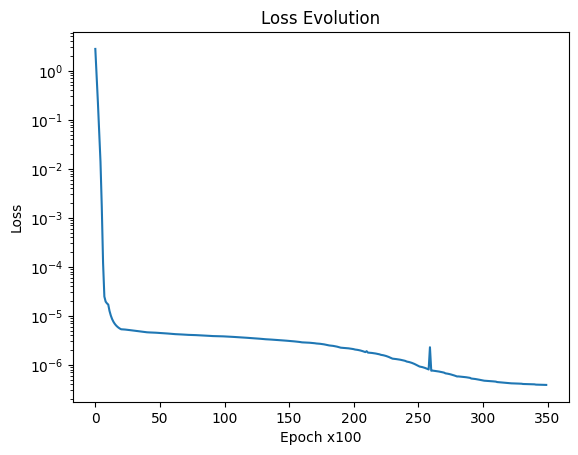

In [163]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [164]:
#res_05 = outputs

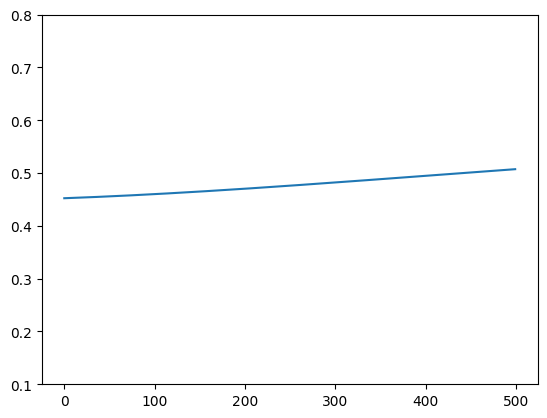

In [165]:
x_flat = jnp.linspace(0, L, 500)
outputs = jax.vmap(model)(x_flat)

plt.plot(outputs)
#plt.plot(res_05)
plt.ylim([0.1, 0.8])
plt.show()

In [166]:
def get_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.weight)
    return weights

In [167]:
trained_weights_20 = get_weights(model)
trained_weights_20

[Array([[-0.04254527],
        [ 0.33715424],
        [ 0.141681  ]], dtype=float32),
 Array([[-0.1081215 , -0.15566464,  0.32767633],
        [ 0.367235  , -0.02051526, -0.02971581],
        [ 0.23570417, -0.21239458,  0.36068884]], dtype=float32),
 Array([[ 0.0132234 ,  0.07409297, -0.5154424 ],
        [-0.6812576 , -0.15406713, -1.1681477 ],
        [ 0.4074215 ,  0.34003633,  0.7167726 ]], dtype=float32),
 Array([[ 0.50803727,  0.928457  , -0.3368352 ]], dtype=float32)]

In [90]:
trained_weights_13

[Array([[-0.96920633],
        [-0.21822791],
        [ 0.29022127]], dtype=float32),
 Array([[-0.28838858, -0.75741637,  1.0821025 ],
        [ 1.2496676 , -0.41639695,  0.7548787 ],
        [-0.6560423 , -0.30473167,  0.22558025]], dtype=float32),
 Array([[ 0.6047695 ,  0.30794516, -1.9769242 ],
        [-0.029636  ,  0.0952063 , -1.6092075 ],
        [ 2.4776468 ,  1.7182634 ,  1.8688555 ]], dtype=float32),
 Array([[ 1.3372387,  0.9237862, -0.9804542]], dtype=float32)]

In [107]:
trained_weights_14

[Array([[-1.3445711 ],
        [-0.14431378],
        [ 0.25982085]], dtype=float32),
 Array([[ 0.15228455, -0.97120446,  1.2853887 ],
        [ 1.6770507 , -0.5162236 ,  0.68535227],
        [-0.4244197 , -0.3043291 ,  0.28893018]], dtype=float32),
 Array([[ 0.3420103 ,  0.8109512 , -1.905076  ],
        [-0.16676   ,  0.52782726, -1.666369  ],
        [ 2.2207603 ,  1.8605554 ,  2.0890923 ]], dtype=float32),
 Array([[ 1.8273108 ,  0.91693723, -1.1164877 ]], dtype=float32)]

In [125]:
trained_weights_15

[Array([[-0.5241256 ],
        [-0.21573873],
        [ 0.3313032 ]], dtype=float32),
 Array([[-1.0207063 ,  0.08536342,  0.33633563],
        [ 0.5236422 , -1.095865  ,  1.0080228 ],
        [ 0.21890333, -1.0946387 ,  0.6066774 ]], dtype=float32),
 Array([[-1.5201625 ,  0.33186486,  0.21785122],
        [-1.8903639 ,  0.09989613, -0.15357812],
        [ 1.0274642 ,  0.48278713,  2.1771574 ]], dtype=float32),
 Array([[ 0.9638703 ,  0.85128444, -0.8998888 ]], dtype=float32)]

In [142]:
trained_weights_16

[Array([[-0.23187035],
        [-0.12981267],
        [ 0.34534997]], dtype=float32),
 Array([[-0.79196185, -0.04560323,  0.4550504 ],
        [-1.205227  ,  0.3105434 , -0.26399755],
        [ 0.34126824, -1.0391583 ,  0.83689   ]], dtype=float32),
 Array([[ 0.173946  ,  0.20631786, -0.27349743],
        [-0.71759635, -0.7629724 , -0.36605158],
        [ 1.1542053 ,  0.02751279,  1.8245437 ]], dtype=float32),
 Array([[-0.25774518,  0.90693957, -0.8344737 ]], dtype=float32)]

Ideia de distancia: Mede a distancia entre cada uma das matrizes. Coloque esses valores num vetor e meça a distancia euclidiana desse vetor. Pode colocar um peso para cada posição do vetor, sendo quando mais para a entrada, maior o peso, já que a parada se propaga, mas não tenho certeza se é necessário.

In [68]:
import jax.numpy as jnp

def sum_squared_differences(list1, list2):
    """
    Calculate the sum of squared differences element-wise for two lists of jnp.arrays.

    Parameters:
    list1 (list of jnp.array): First list of arrays.
    list2 (list of jnp.array): Second list of arrays.

    Returns:
    float: Sum of squared differences.
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length")
    
    total_sum = 0.0
    for arr1, arr2 in zip(list1, list2):
        total_sum += jnp.sum((arr1 - arr2) ** 2)
    
    return total_sum
